# ADS 509 Team 1 Final Project

## Tweets Classification on Cryptocurrencies

### University of San Diego - Applied Data Science

#### Chow, Eva
#### Duan, Dingyi 
#### Tan, Abby

### Load Necessary Libraries

In [28]:
# import some necessary libraries

#!pip install psawimport datetime as dt
import os
import re
import nltk
import demoji
import random
import tweepy
import numpy as np
import pandas as pd
import seaborn as sns
import nltk.classify
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix
from collections import Counter, defaultdict
from lexical_diversity import lex_div as ld
from matplotlib import pyplot as plt
from datetime import datetime as dt
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from string import punctuation
from sklearn import metrics

In [2]:
from api_keys import api_key, api_key_secret, bearer_token
client = tweepy.Client(bearer_token,wait_on_rate_limit=True)

In [3]:
# prepare our crypto candidates
handles = ["Bitcoin", "ethereum", "Cardano", "dogecoin", "ShibainuCoin"]
tweets_data = dict()

### Pulling Request Using Tweepy

In [4]:
# set up tweepy request
# pull max of 1500 tweets per crypto if possible
max_pulls = 10

for handle in handles:
    
    pulls = 0
    tweets_data[handle] = []
    user_obj = client.get_user(username=handle)
    
    for response in tweepy.Paginator(client.get_users_tweets,
                                     user_obj.data.id,
                                     max_results=100):
        
        print(pulls+1, "pulls completed for", handle)
        pulls += 1

        for tws in response.data:
            tweets_data[handle].append(tws.text)
        if 'next_token' in response.meta and pulls < max_pulls :
            next_token = response.meta['next_token']
        else : 
            break

1 pulls completed for Bitcoin
2 pulls completed for Bitcoin
3 pulls completed for Bitcoin
4 pulls completed for Bitcoin
5 pulls completed for Bitcoin
6 pulls completed for Bitcoin
7 pulls completed for Bitcoin
8 pulls completed for Bitcoin
9 pulls completed for Bitcoin
10 pulls completed for Bitcoin
1 pulls completed for ethereum
2 pulls completed for ethereum
3 pulls completed for ethereum
4 pulls completed for ethereum
5 pulls completed for ethereum
6 pulls completed for ethereum
7 pulls completed for ethereum
8 pulls completed for ethereum
9 pulls completed for ethereum
10 pulls completed for ethereum
1 pulls completed for Cardano
2 pulls completed for Cardano
3 pulls completed for Cardano
4 pulls completed for Cardano
5 pulls completed for Cardano
6 pulls completed for Cardano
7 pulls completed for Cardano
8 pulls completed for Cardano
9 pulls completed for Cardano
10 pulls completed for Cardano
1 pulls completed for dogecoin
2 pulls completed for dogecoin
3 pulls completed for dog

In [5]:
# store our tweets in a dataframe for convenience
tweets_df = (pd.DataFrame(tweets_data.items(), columns=['crypto_type', 'tweets'])).explode('tweets').reset_index(drop=True)
tweets_df

,crypto_type,tweets
0,Bitcoin,RT @bitcoin_ring: Bear markets are for buildin...
1,Bitcoin,"If #Bitcoin stays between $15,000-30,000 then ..."
2,Bitcoin,#Bitcoin volatility has come way down. https:/...
3,Bitcoin,RT @zerohedge: You mean even worse than the wo...
4,Bitcoin,"Last week, retail traders bought $19.9 billion..."
...,...,...
4727,ShibainuCoin,$SHIB\nLet's build the strongest🐶community in ...
4728,ShibainuCoin,We are in #Coingecko \n\nhttps://t.co/E8YIc9cVu8
4729,ShibainuCoin,@TheMoonCarl $SHIB
4730,ShibainuCoin,Join the SHIB ARMY on Telegram\n\nhttps://t.co...


In [6]:
tweets_df.shape

(4732, 2)

In [7]:
tweets_df['crypto_type'].value_counts().reset_index(name='number of tweets')

,index,number of tweets
0,Bitcoin,1000
1,ethereum,1000
2,Cardano,998
3,dogecoin,962
4,ShibainuCoin,772


### Cleaning Tweet

In [8]:
# punctuation variations
punctuation = set(punctuation) # speeds up comparison

tw_punct = punctuation #- {"#"} # remove hashtags from punctuation list

# stopwords
sw = stopwords.words("english")
sw = [i.replace("'","") for i in sw]  # remove single quote from sw

# remove retweet word

sw.extend(['rt', 'retweet'])

# we don't really need the actual names of the cryptos especially
# when the hashtags are removed
sw.extend(['bitcoin', 'ethereum', 'cardano','dogecoin','shib','shiba'])



# some useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")



def descriptive_stats(tokens,handle) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = ld.ttr(tokens)
    num_characters = sum([len(token) for token in tokens])
    top5_tokens = Counter(tokens).most_common()[:5]
    
    print("For", handle, ": \n")
    print(f"There are {num_tokens} tokens in the data.")
    print(f"There are {num_unique_tokens} unique tokens in the data.")
    print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    print(f"There are {num_characters} characters in the data.")
    print(f"These are the five most common tokens in the data: {top5_tokens}.")

    return "\n\n"

# text cleaning functions
def remove_url(s): 
    return re.sub(r'http\S+', '', s)

def lower_case(text):
    return text.casefold()
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    return text.split()

def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [i for i in tokens if not i in sw]
    return tokens

def remove_emoji(tokens) :
    dem = demoji.findall(tokens)
    for item in dem.keys():
        tokens = tokens.replace(item, ' ')
    return tokens

# pipeline implementation
def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return tokens


### Tokenization and Normalization

**Cleaning steps** 

* remove urls
* Casefold to lowercase
* Remove punctuation other than hashtags
* Split on whitespace
* Remove stopwords
* Remove emoji

In [9]:
crypto_pipeline1 = [remove_url, lower_case, remove_punctuation, tokenize, remove_stop]
# crypto_pipeline = [remove_url, lower_case, remove_punctuation, tokenize, remove_stop]
tweets_df["tokens"] = tweets_df["tweets"].apply(prepare,pipeline=crypto_pipeline1)
tweets_df["num_tokens"] = tweets_df["tokens"].map(len) 

In [10]:
tweets_df

,crypto_type,tweets,tokens,num_tokens
0,Bitcoin,RT @bitcoin_ring: Bear markets are for buildin...,"[bitcoinring, bear, markets, building]",4
1,Bitcoin,"If #Bitcoin stays between $15,000-30,000 then ...","[stays, 1500030000, many, years, willing, hodl]",6
2,Bitcoin,#Bitcoin volatility has come way down. https:/...,"[volatility, come, way]",3
3,Bitcoin,RT @zerohedge: You mean even worse than the wo...,"[zerohedge, mean, even, worse, worst, 40, years]",7
4,Bitcoin,"Last week, retail traders bought $19.9 billion...","[last, week, retail, traders, bought, 199, bil...",31
...,...,...,...,...
4727,ShibainuCoin,$SHIB\nLet's build the strongest🐶community in ...,"[lets, build, strongest🐶community, tweeter, hi...",8
4728,ShibainuCoin,We are in #Coingecko \n\nhttps://t.co/E8YIc9cVu8,[coingecko],1
4729,ShibainuCoin,@TheMoonCarl $SHIB,[themooncarl],1
4730,ShibainuCoin,Join the SHIB ARMY on Telegram\n\nhttps://t.co...,"[join, army, telegram]",3


### Calculate Descriptive Statistics On the Cryptos Tokens.

In [11]:
for handle in handles:
    token_sum = []
    start_index = tweets_df['crypto_type'].ne(handle).idxmin()
    end_index = len(tweets_df.loc[tweets_df['crypto_type'] == handle])
    for i in range(start_index, start_index+end_index):
        token_row = tweets_df['tokens'].loc[tweets_df['crypto_type'] == handle][i] 
        token_sum = token_sum + token_row # use + to stitch all list together
    print(descriptive_stats(token_sum, handle))

For Bitcoin : 

There are 9330 tokens in the data.
There are 4088 unique tokens in the data.
The lexical diversity is 0.438 in the data.
There are 56599 characters in the data.
These are the five most common tokens in the data: [('btc', 67), ('price', 61), ('market', 47), ('inflation', 45), ('2021', 42)].



For ethereum : 

There are 12514 tokens in the data.
There are 4194 unique tokens in the data.
The lexical diversity is 0.335 in the data.
There are 77066 characters in the data.
These are the five most common tokens in the data: [('latest', 143), ('new', 135), ('eth2', 126), ('week', 117), ('news', 102)].



For Cardano : 

There are 12645 tokens in the data.
There are 4069 unique tokens in the data.
The lexical diversity is 0.322 in the data.
There are 88130 characters in the data.
These are the five most common tokens in the data: [('cardanocommunity', 234), ('cardanostiftung', 231), ('blockchain', 140), ('join', 120), ('amp', 108)].



For dogecoin : 

There are 9556 tokens in 

### Build Word Clouds For All The Cryptos. 

In [12]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if sw is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in sw}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

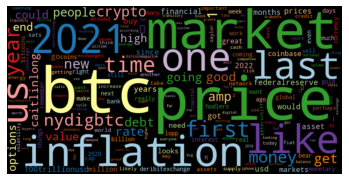

In [13]:
wc1 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'Bitcoin'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc1['freq'], title=None, max_words=200, stopwords=None)

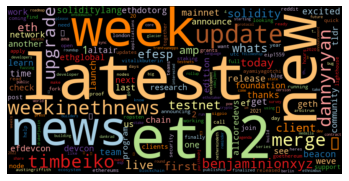

In [14]:
wc2 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'ethereum'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc2['freq'], title=None, max_words=200, stopwords=None)

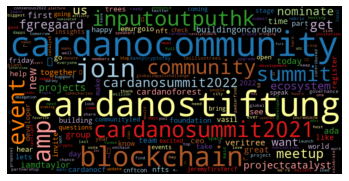

In [15]:
wc3 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'Cardano'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc3['freq'], title=None, max_words=200, stopwords=None)

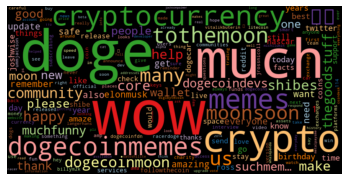

In [16]:
wc4 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'dogecoin'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc4['freq'], title=None, max_words=200, stopwords=None)

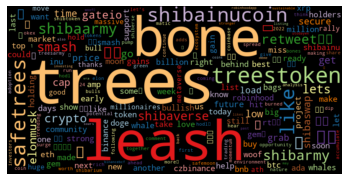

In [17]:
wc5 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'ShibainuCoin'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc5['freq'], title=None, max_words=200, stopwords=None)

### Classification Models

In [18]:
all_tokens = []
for i in tweets_df['tokens']:
    all_tokens += i

# look at some random sampling tokens
print(random.sample(all_tokens, 20))

['treestoken', 'slight', 'event', '080', 'spruceid', 'reveal', 'cardanosummit2022', 'celebrating', 'swapped', 'head', 'lot', 'constant', 'one', 'bullish', 'go', 'great', 'meltdowns', 'coins', '50', 'we’re']


In [19]:
word_cutoff = 5
word_dist = nltk.FreqDist(all_tokens)
feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model (including emojis).")

With a word cutoff of 5, we have 1805 as features in the model (including emojis).


In [20]:
# look at some random sampling feature words
print(random.sample(feature_words, 20))

['included', 'amp…', 'many', '7', 'certik', 'higher', 'massive', 'results', '🌳🌳🌳', 'wealth', 'teku', 'celebrating', 'vroom', 'digibytecoin', 'targets', 'uniswap', '63', '68', 'sound', 'attend']


In [21]:
def conv_features(text,fw) :
    
    ret_word = [i for i in text]
    ret_bool = [True if i in fw else False for i in text]
    
    ret_dict = dict(zip(ret_word,ret_bool))
    
    return(ret_dict)

In [22]:
convention_data = [[tweets_df['tokens'][i], tweets_df['crypto_type'][i]] for i in range(len(tweets_df))]

In [23]:
featuresets = [(conv_features(tokens,feature_words), crypto) for (tokens, crypto) in convention_data]

Each of the tweet contains a feature set, let's print some feature sets

In [24]:
print(featuresets[:3])

[({'bitcoinring': False, 'bear': True, 'markets': True, 'building': True}, 'Bitcoin'), ({'stays': False, '1500030000': False, 'many': True, 'years': True, 'willing': False, 'hodl': True}, 'Bitcoin'), ({'volatility': True, 'come': True, 'way': True}, 'Bitcoin')]


In [25]:
random.seed(1314)
random.shuffle(featuresets)

# choose train:test = 7:3 
test_size = round(len(featuresets)*(3/10))
test_size

1420

#### Naive Bayes
##### 1. With emoji

In [49]:
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print('The training set accuracy for Naive Bayes model with emojis is:',round(nltk.classify.accuracy(classifier, train_set),3))

The training set accuracy for Naive Bayes model with emojis is: 0.959


Let's look at the top 25 most informative features/tokens of our model

In [27]:
classifier.show_most_informative_features(25)

Most Informative Features
                   trees = True           Shibai : ethere =    218.3 : 1.0
                      ❤️ = True           Shibai : ethere =    173.5 : 1.0
                       💎 = True           Shibai : ethere =    164.0 : 1.0
                       🌳 = True           Shibai : ethere =    134.5 : 1.0
        cardanocommunity = True           Cardan : Shibai =     90.9 : 1.0
         cardanostiftung = True           Cardan : Shibai =     84.4 : 1.0
                     wow = True           dogeco : Shibai =     84.3 : 1.0
                       🔥 = True           Shibai : Bitcoi =     58.0 : 1.0
                    join = True           Cardan : Bitcoi =     55.9 : 1.0
                  latest = True           ethere : Shibai =     54.7 : 1.0
              blockchain = True           Cardan : Shibai =     50.4 : 1.0
                     low = True           Shibai : Cardan =     44.9 : 1.0
                     cap = True           Shibai : dogeco =     44.8 : 1.0

For the 25 most informative features, 6 of them are emojis and top5 features have 3 emojis!

All of them emoji features are pointing out that for Shiba Inu's tweets are symbolic for its use of emojis.

Let's run some prediction on the test set

In [29]:
cryptos = handles
results = defaultdict(lambda: defaultdict(int))

random.shuffle(test_set)

for idx, tp in enumerate(test_set) :
    tokens, crypto = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_crypto = classifier.classify(conv_features(tokens,feature_words))
    
    results[crypto][estimated_crypto] += 1


In [30]:
results

defaultdict(<function __main__.<lambda>()>,
            {'Cardano': defaultdict(int,
                         {'Cardano': 297, 'ethereum': 6, 'ShibainuCoin': 11}),
             'dogecoin': defaultdict(int,
                         {'dogecoin': 219,
                          'ShibainuCoin': 33,
                          'ethereum': 22,
                          'Cardano': 21,
                          'Bitcoin': 5}),
             'ethereum': defaultdict(int,
                         {'ethereum': 252,
                          'Cardano': 14,
                          'dogecoin': 2,
                          'Bitcoin': 4,
                          'ShibainuCoin': 10}),
             'Bitcoin': defaultdict(int,
                         {'Cardano': 14,
                          'Bitcoin': 195,
                          'ethereum': 48,
                          'dogecoin': 10,
                          'ShibainuCoin': 37}),
             'ShibainuCoin': defaultdict(int,
                       

Let's look at some confusion matrix for better visual

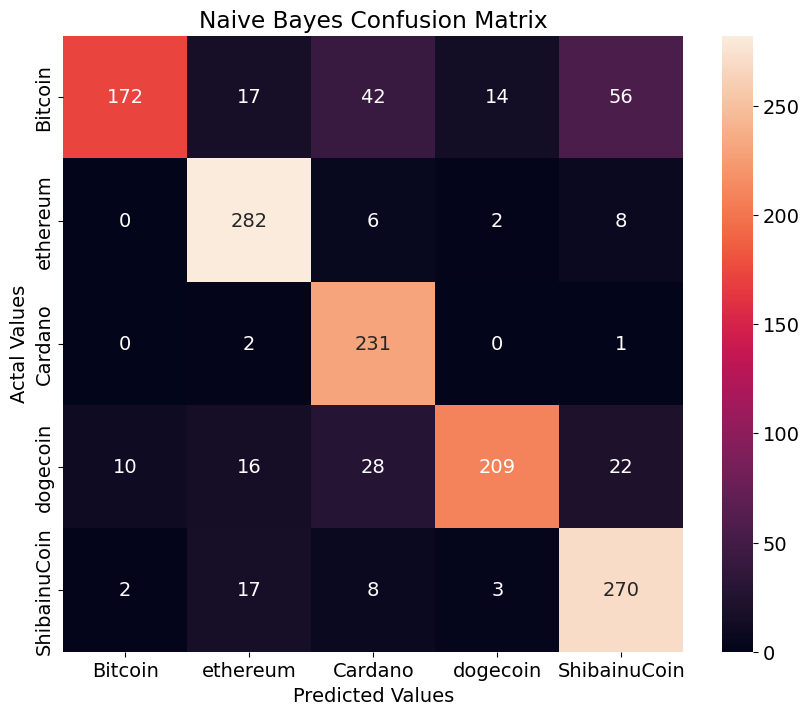



The test set accuracy of Naive Bayes model with emojis: 0.821


In [82]:
actual = [test_set[i][1] for i in range(len(test_set))]
predicted = [classifier.classify(conv_features(test_set[i][0],feature_words)) for i in range(len(test_set))] 

cm = confusion_matrix(actual, predicted)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm, index = handles, columns = handles)

#Plotting the confusion matrix
font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy
print('\n')
print("The test set accuracy of Naive Bayes model with emojis:", round(compute_accuracy(actual, predicted),3))

Accuracy of 0.959 for training and 0.829 for test is very good for our model performance.

We suspect that the emojis are playing a significant role in the model performance as they can be unique to certain type of coins.

We will now remove the emojis and see if our hypothesis is correct.

##### 2. Without emoji

In [62]:
# a different pipeline including remove_emoji 
crypto_pipeline2 = [remove_url, lower_case, remove_punctuation, remove_emoji, tokenize, remove_stop]

# add a new column for tokens without emojis
tweets_df["tokens_no_emoji"] = tweets_df["tweets"].apply(prepare,pipeline=crypto_pipeline2)

In [63]:
all_tokens_no_emoji = []
for i in tweets_df['tokens_no_emoji']:
    all_tokens_no_emoji += i

# look at some random sampling tokens
print(random.sample(all_tokens_no_emoji, 20))

['happy', 'stop', 'wow', 'another', 'independent', '46', 'skill', 'bots', 'chickun', 'follow', 'doge', 'holding', 'free', 'pow', 'like', 'seconds', 'community', 'yields', 'mail', 'read']


In [64]:
word_cutoff = 5
word_dist = nltk.FreqDist(all_tokens_no_emoji)
feature_words_no_emoji = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words_no_emoji.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words_no_emoji)} as features in the model (without emojis).")

With a word cutoff of 5, we have 1723 as features in the model (without emojis).


Compared to 1812 features with emojis included, we removed 89 emojis from the feature sets

In [65]:
convention_data_no_emoji = [[tweets_df['tokens_no_emoji'][i], tweets_df['crypto_type'][i]] for i in range(len(tweets_df))]
featuresets_no_emoji = [(conv_features(tokens,feature_words_no_emoji), crypto) for (tokens, crypto) in convention_data_no_emoji]

In [66]:
random.seed(1314)
random.shuffle(featuresets)

# choose train:test = 7:3 
test_size_no_emoji = round(len(featuresets_no_emoji)*(3/10))
test_size_no_emoji

1418

In [67]:
test_set_no_emoji, train_set_no_emoji = featuresets_no_emoji[:test_size_no_emoji], featuresets_no_emoji[test_size_no_emoji:]
classifier_no_emoji = nltk.NaiveBayesClassifier.train(train_set_no_emoji)
print('The training set accuracy for Naive Bayes model without emojis is:"',round(nltk.classify.accuracy(classifier_no_emoji, train_set),3))

The training set accuracy for Naive Bayes model without emojis is:" 0.767


In [68]:
classifier_no_emoji.show_most_informative_features(25)

Most Informative Features
                   trees = True           Shibai : ethere =    297.3 : 1.0
        cardanocommunity = True           Cardan : Shibai =    126.0 : 1.0
                     low = True           Shibai : Cardan =     72.9 : 1.0
         cardanostiftung = True           Cardan : Shibai =     71.2 : 1.0
                    doge = True           dogeco : ethere =     71.0 : 1.0
                     cap = True           Shibai : dogeco =     69.2 : 1.0
                     wow = True           dogeco : Shibai =     66.2 : 1.0
                    grab = True           Shibai : Cardan =     57.4 : 1.0
                   price = True           Shibai : Cardan =     56.5 : 1.0
                  secure = True           Shibai : dogeco =     52.6 : 1.0
                  latest = True           ethere : dogeco =     50.4 : 1.0
                    load = True           Shibai : dogeco =     49.3 : 1.0
                   memes = True           dogeco : Shibai =     40.5 : 1.0

In [69]:
cryptos = handles
results = defaultdict(lambda: defaultdict(int))

random.shuffle(test_set)

for idx, tp in enumerate(test_set) :
    tokens, crypto = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_crypto_no_emoji = classifier_no_emoji.classify(conv_features(tokens,feature_words_no_emoji))
    
    results[crypto][estimated_crypto_no_emoji] += 1


In [70]:
results

defaultdict(<function __main__.<lambda>()>,
            {'Bitcoin': defaultdict(int,
                         {'ShibainuCoin': 131,
                          'ethereum': 44,
                          'Cardano': 90,
                          'dogecoin': 36}),
             'Cardano': defaultdict(int,
                         {'Cardano': 292,
                          'ethereum': 2,
                          'ShibainuCoin': 3,
                          'dogecoin': 1}),
             'ethereum': defaultdict(int,
                         {'ethereum': 281,
                          'dogecoin': 3,
                          'Cardano': 15,
                          'ShibainuCoin': 1}),
             'ShibainuCoin': defaultdict(int, {'ShibainuCoin': 234}),
             'dogecoin': defaultdict(int,
                         {'dogecoin': 266,
                          'ShibainuCoin': 6,
                          'ethereum': 4,
                          'Cardano': 9})})

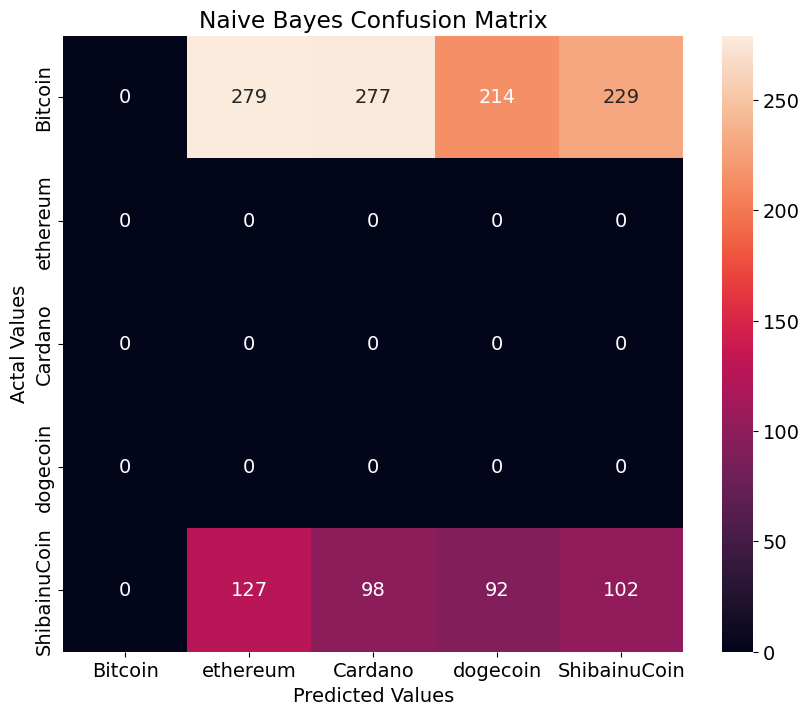



The test set accuracy of Naive Bayes model without emojis: 0.072


In [81]:
actual_no_emoji = [test_set_no_emoji[i][1] for i in range(len(test_set_no_emoji))]
predicted_no_emoji = [classifier_no_emoji.classify(conv_features(test_set[i][0],feature_words_no_emoji)) for i in range(len(test_set_no_emoji))] 

cm_no_emoji = confusion_matrix(actual_no_emoji, predicted_no_emoji)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_no_emoji = pd.DataFrame(cm_no_emoji, index = handles, columns = handles)

#Plotting the confusion matrix
font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df_no_emoji, annot=True,fmt='g')
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print('\n')
print("The test set accuracy of Naive Bayes model without emojis:", round(compute_accuracy(actual_no_emoji, predicted_no_emoji),3))

WOW! With an accuracy score on training set of 0.767 and less than 0.1 on test set of mere 0.072, our model could barely recognize anything cryptocurrency using words alone without any emojis!

This results confirms that our hypothesis is proven to be correct and it is a learnt fact that emojis are indeed a key factor for classifying different cryptocurrencies.

#### SVM

In [72]:
classifier_svm = nltk.classify.SklearnClassifier(LinearSVC())
classifier_svm.train(train_set)
print('The training set accuracy for SVM model is:',round(nltk.classify.accuracy(classifier_svm, train_set),3))

The training set accuracy for SVM model is: 0.981


In [44]:
cryptos = handles
results = defaultdict(lambda: defaultdict(int))

random.shuffle(test_set)

for idx, tp in enumerate(test_set) :
    tokens, crypto = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_crypto = classifier_svm.classify(conv_features(tokens,feature_words))
    
    results[crypto][estimated_crypto] += 1

In [45]:
results

defaultdict(<function __main__.<lambda>()>,
            {'Bitcoin': defaultdict(int,
                         {'Bitcoin': 268,
                          'ethereum': 11,
                          'dogecoin': 19,
                          'Cardano': 5,
                          'ShibainuCoin': 1}),
             'ethereum': defaultdict(int,
                         {'ethereum': 237,
                          'Bitcoin': 24,
                          'ShibainuCoin': 2,
                          'dogecoin': 15,
                          'Cardano': 4}),
             'dogecoin': defaultdict(int,
                         {'dogecoin': 215,
                          'ethereum': 17,
                          'Bitcoin': 54,
                          'ShibainuCoin': 5,
                          'Cardano': 9}),
             'Cardano': defaultdict(int,
                         {'Cardano': 273,
                          'Bitcoin': 18,
                          'ethereum': 14,
                          

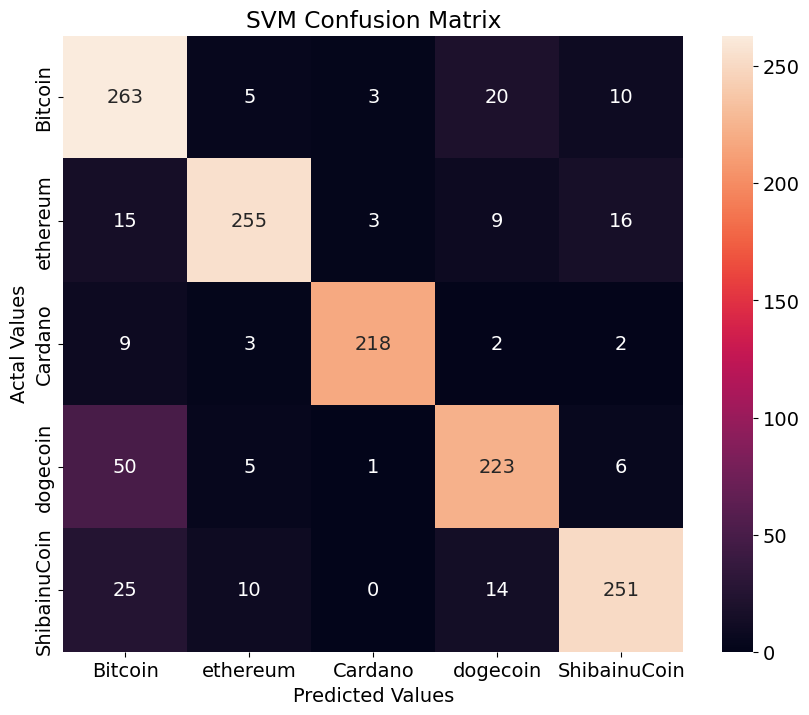



The test set accuracy of SVM model is: 0.853


In [80]:
actual_svm = [test_set[i][1] for i in range(len(test_set))]
predicted_svm = [classifier_svm.classify(conv_features(test_set[i][0],feature_words)) for i in range(len(test_set))] 

cm_svm = confusion_matrix(actual_svm, predicted_svm)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_svm_df = pd.DataFrame(cm_svm, index = handles, columns = handles)

#Plotting the confusion matrix
font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(10,8))
sns.heatmap(cm_svm_df, annot=True,fmt='g')
plt.title('SVM Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print('\n')
print("The test set accuracy of SVM model is:", round(compute_accuracy(actual_svm, predicted_svm),3))

In [92]:
class_compare = pd.DataFrame({
                            'Models': ['Naive Bayes', 'SVM'],
                            'Training Accuracy': [round(nltk.classify.accuracy(classifier, train_set),3), round(nltk.classify.accuracy(classifier_svm, train_set),3)],
                            'Test Accuracy': [round(compute_accuracy(actual, predicted),3), round(compute_accuracy(actual_svm, predicted_svm),3)]
                             })
class_compare

,Models,Training Accuracy,Test Accuracy
0,Naive Bayes,0.959,0.821
1,SVM,0.981,0.853


Both models have been performing with acceptable result and SVM outperforms Naive Bayes slightly with 0.981 of training accuracy and 0.853 test accuracy.

### Topic Modeling

In [26]:
tweets_df.head()

,crypto_type,tweets,tokens,num_tokens
0,Bitcoin,"In seven months, record QE to record QT with $...","[seven, months, record, qe, record, qt, 31, tr...",13
1,Bitcoin,https://t.co/cxaFr07JFM,[],0
2,Bitcoin,👀 https://t.co/DOspMAQdag,[👀],1
3,Bitcoin,RT @lopp: In 2018 the success rate of a $5 pay...,"[lopp, 2018, success, rate, 5, payment, via, l...",17
4,Bitcoin,Which #Bitcoin bear market has felt longer; 20...,"[bear, market, felt, longer, 2018, 2022]",6


In [27]:
# Let's add some helpful columns on the df
tweets_df['char_len'] = tweets_df['tweets'].apply(len)
tweets_df['word_len'] = tweets_df['tweets'].apply(lambda x: len(x.split()))
tweets_df.head()

,crypto_type,tweets,tokens,num_tokens,char_len,word_len
0,Bitcoin,"In seven months, record QE to record QT with $...","[seven, months, record, qe, record, qt, 31, tr...",13,122,18
1,Bitcoin,https://t.co/cxaFr07JFM,[],0,23,1
2,Bitcoin,👀 https://t.co/DOspMAQdag,[👀],1,25,2
3,Bitcoin,RT @lopp: In 2018 the success rate of a $5 pay...,"[lopp, 2018, success, rate, 5, payment, via, l...",17,140,24
4,Bitcoin,Which #Bitcoin bear market has felt longer; 20...,"[bear, market, felt, longer, 2018, 2022]",6,81,11


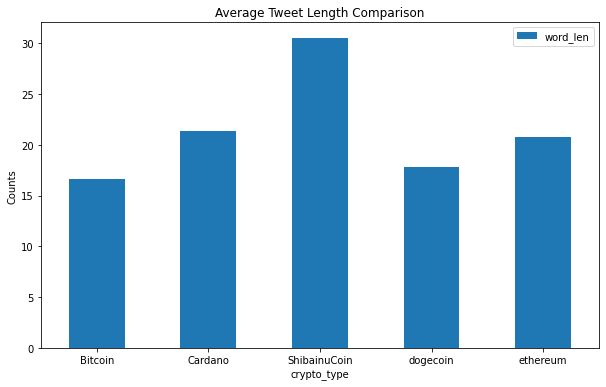

In [28]:
%matplotlib inline
# checking to see which crypto has the most words
tweets_df.groupby('crypto_type').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6), rot = 0,ylabel = 'Counts',title = 'Average Tweet Length Comparison')

Shiba Inu has the longest average tweet length while Bitcoin has surprisingly the shortest!

#### Count and TF-IDF vectorizations.

In [29]:
# using a cutoff of minimum of 5 words and 70% as maximum.
count_tweet_vectorizer = CountVectorizer(stop_words=sw, min_df=5, max_df=0.7)
count_tweet_vectors = count_tweet_vectorizer.fit_transform(tweets_df["tweets"])
count_tweet_vectors.shape

(4728, 1937)

In [30]:
pd.DataFrame(count_tweet_vectors.todense())

,0,1,2,3,4,5,6,7,8,9,...,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
tfidf_tweet_vectorizer = TfidfVectorizer(stop_words=sw, min_df=5, max_df=0.7)
tfidf_tweet_vectors = tfidf_tweet_vectorizer.fit_transform(tweets_df['tweets'])
tfidf_tweet_vectors.shape

(4728, 1937)

In [32]:
pd.DataFrame(tfidf_tweet_vectors.todense())

,0,1,2,3,4,5,6,7,8,9,...,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The `count_tweet_vectors` holds the absolute counts for each word in different corpura while
the TfidfTransformer (`tfidf_tweet_vectors`) transforms this count matrix to a 
normalized tf or tf-idf representation in float format (percentage).

The two topic-document matrice can help understand the dimensionality of the keywords and documents.

#### Display Topics Function

In [36]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

#### Non-Negative Matrix Factorization

In [41]:
nmf_tweet_model = NMF(n_components=5, random_state=314)
W_tweet_matrix = nmf_tweet_model.fit_transform(tfidf_tweet_vectors)
H_tweet_matrix = nmf_tweet_model.components_

In [42]:
display_topics(nmf_tweet_model, tfidf_tweet_vectorizer.get_feature_names())


Topic 00
 https (24.68)
 co (23.72)
 go (0.42)
 doge (0.41)
 got (0.41)

Topic 01
 trees (3.44)
 leash (3.03)
 bone (3.03)
 trees_token (2.98)
 safetrees (2.70)

Topic 02
 doge (7.72)
 wow (7.51)
 dogecoinmemes (7.20)
 memes (7.19)
 tothemoon (7.16)

Topic 03
 http (11.94)
 much (10.47)
 wow (8.77)
 co (4.11)
 many (1.35)

Topic 04
 cardanocommunity (2.77)
 event (1.94)
 cardanosummit2021 (1.93)
 join (1.78)
 summit (1.73)


In [43]:
nmf_W_tweet_matrix = pd.DataFrame(W_tweet_matrix)
nmf_W_tweet_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
nmf_W_tweet_matrix['Topic'] = nmf_W_tweet_matrix.idxmax(axis=1)

In [48]:
nmf_topic = pd.concat([nmf_W_tweet_matrix[['Topic']], tweets_df[['crypto_type']]], axis=1 )

In [49]:
nmf_topic.head(3)

,Topic,crypto_type
0,Topic 00,Bitcoin
1,Topic 00,Bitcoin
2,Topic 00,Bitcoin


In [50]:
nmf_topic.groupby('Topic')['crypto_type'].value_counts()

Topic     crypto_type 
Topic 00  Bitcoin         667
          ethereum        304
          dogecoin        274
          Cardano         171
          ShibainuCoin     77
Topic 01  ShibainuCoin    662
          Bitcoin          90
          dogecoin         28
          Cardano          23
          ethereum         23
Topic 02  dogecoin        138
          Bitcoin          22
          ShibainuCoin     11
          Cardano           6
          ethereum          5
Topic 03  dogecoin        349
          Bitcoin          27
          Cardano           9
          ethereum          9
          ShibainuCoin      2
Topic 04  Cardano         789
          ethereum        659
          Bitcoin         194
          dogecoin        169
          ShibainuCoin     20
Name: crypto_type, dtype: int64

#### Latent Semantic Analysis

In [51]:
svd_tweet_model = TruncatedSVD(n_components=5, n_iter=7, random_state=314)
svd_W_tweet_matrix = svd_tweet_model.fit_transform(tfidf_tweet_vectors)
svd_H_tweet_matrix = svd_tweet_model.components_

In [56]:
display_topics(svd_tweet_model, tfidf_tweet_vectorizer.get_feature_names())


Topic 00
 https (11.12)
 co (10.96)
 trees (0.85)
 like (0.73)
 wow (0.71)

Topic 01
 trees (3.30)
 leash (2.91)
 bone (2.90)
 trees_token (2.86)
 safetrees (2.59)

Topic 02
 wow (10.93)
 doge (6.20)
 http (5.01)
 crypto (4.95)
 much (4.95)

Topic 03
 http (14.18)
 much (11.63)
 wow (4.30)
 co (1.69)
 update (1.68)

Topic 04
 cardanocommunity (2.95)
 event (2.11)
 cardanosummit2021 (2.10)
 join (1.91)
 summit (1.88)


In [52]:
svd_W_tweet_matrix = pd.DataFrame(svd_W_tweet_matrix)
svd_W_tweet_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
svd_W_tweet_matrix['Topic'] = svd_W_tweet_matrix.idxmax(axis=1)

In [54]:
svd_topic = pd.concat([svd_W_tweet_matrix[['Topic']], tweets_df[['crypto_type']]], axis=1 )
svd_topic.head(3)

,Topic,crypto_type
0,Topic 00,Bitcoin
1,Topic 00,Bitcoin
2,Topic 00,Bitcoin


In [55]:
svd_topic.groupby('Topic')['crypto_type'].value_counts()

Topic     crypto_type 
Topic 00  Bitcoin         690
          ethereum        364
          dogecoin        344
          Cardano         282
          ShibainuCoin    135
Topic 01  ShibainuCoin    619
          Bitcoin         114
          dogecoin         36
          Cardano          34
          ethereum         30
Topic 02  dogecoin        236
          Bitcoin          17
          Cardano           9
          ethereum          6
          ShibainuCoin      3
Topic 03  dogecoin        199
          Bitcoin          18
          ethereum          9
          Cardano           2
          ShibainuCoin      1
Topic 04  Cardano         671
          ethereum        591
          Bitcoin         161
          dogecoin        143
          ShibainuCoin     14
Name: crypto_type, dtype: int64

#### Latent Dirichlet Allocation

In [58]:
lda_tweet_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_W_tweet_matrix = lda_tweet_model.fit_transform(count_tweet_vectors)
lda_H_tweet_matrix = lda_tweet_model.components_

In [64]:
display_topics(lda_tweet_model, tfidf_tweet_vectorizer.get_feature_names())


Topic 00
 co (4.03)
 https (2.39)
 http (1.62)
 wow (1.60)
 much (1.59)

Topic 01
 https (5.46)
 co (5.39)
 trees (4.90)
 like (3.44)
 leash (3.37)

Topic 02
 new (2.99)
 shibaverse (1.96)
 eth2 (1.72)
 cardanostiftung (1.72)
 secure (1.25)

Topic 03
 co (11.71)
 https (11.61)
 cardanocommunity (1.65)
 join (1.13)
 news (0.97)

Topic 04
 crypto (2.34)
 doge (2.31)
 co (1.75)
 https (1.68)
 wow (1.42)


In [59]:
lda_W_tweet_matrix = pd.DataFrame(lda_W_tweet_matrix)
lda_W_tweet_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
lda_W_tweet_matrix['Topic'] = lda_W_tweet_matrix.idxmax(axis=1)

In [60]:
lda_topic = pd.concat([lda_W_tweet_matrix[['Topic']], tweets_df[['crypto_type']]], axis=1 )
lda_topic.head(3)

,Topic,crypto_type
0,Topic 04,Bitcoin
1,Topic 03,Bitcoin
2,Topic 03,Bitcoin


In [61]:
lda_topic.groupby('Topic')['crypto_type'].value_counts()

Topic     crypto_type 
Topic 00  dogecoin        448
          Bitcoin         227
          ethereum        192
          Cardano         152
          ShibainuCoin     22
Topic 01  ShibainuCoin    707
          Bitcoin          99
          dogecoin         36
          Cardano          19
          ethereum          7
Topic 02  ethereum        226
          Cardano         167
          Bitcoin          63
          dogecoin         28
          ShibainuCoin     10
Topic 03  Cardano         578
          ethereum        449
          Bitcoin         444
          dogecoin        227
          ShibainuCoin     30
Topic 04  dogecoin        219
          Bitcoin         167
          ethereum        126
          Cardano          82
          ShibainuCoin      3
Name: crypto_type, dtype: int64

In [69]:
lda_display = pyLDAvis.sklearn.prepare(lda_tweet_model, count_tweet_vectors, count_tweet_vectorizer, sort_topics=False)

In [70]:
pyLDAvis.display(lda_display)

### Sentiment Assignment

##### Data prep for sentiment words and emojis

In [36]:
# sentiment data
folder_path = os.getcwd() + '\\sentiment\\'
positive_words_file = folder_path + "positive-words.txt"
negative_words_file = folder_path + "negative-words.txt"
tidy_text_file = folder_path + "tidytext_sentiments.txt"
emoji_file = folder_path + 'Emoji_Sentiment_Data_v1.0.csv'

In [45]:
pos_words = pd.read_csv(positive_words_file, sep='\t', encoding='latin-1')
neg_words = pd.read_csv(negative_words_file, sep='\t', encoding='latin-1')
tidy_sen = pd.read_csv(tidy_text_file, sep='\t', encoding='latin-1')
df_emoji_sen = pd.read_csv(emoji_file)

In [46]:
# positive and negative words
pos_words = pos_words[33:]
neg_words = neg_words[33:]
pos_words['score'] = 1
neg_words['score'] = -1
pos_words.columns = ['word','score']
neg_words.columns = ['word','score']

# tidy sentiments
tidy_sen['score'] = np.where(tidy_sen['sentiment'] == 'positive', 1, -1)
tidy_sen = tidy_sen[['word','score']]

In [50]:
# emoji
df_emoji_sen['sentiment'] = df_emoji_sen[['Negative','Neutral','Positive']].idxmax(axis=1)
df_emoji_sen = df_emoji_sen[df_emoji_sen['sentiment'] != 'Neutral']

df_emoji_sen['score'] = np.where(df_emoji_sen['sentiment'] == 'Positive', 1, -1)
df_emoji_sen = df_emoji_sen[['Emoji', 'score']]

df_emoji_sen.columns = ['word', 'score']

In [53]:
# merge
df_sen = pd.concat([pos_words, neg_words, tidy_sen, df_emoji_sen], axis=0)
df_sen = df_sen.drop_duplicates().reset_index(drop=True)
df_sen.shape

(12128, 2)

In [55]:
# convert to dictionary
sen_word = df_sen['word'].to_list()
sen_score = df_sen['score'].to_list()
word_dict = dict(zip(sen_word, sen_score))

##### Sentiment score function

In [56]:
# sentiment score
def sen_score(text):
    sentiment_score = 0
    for word in text:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / (len(text) or not len(text))

In [59]:
tweets_df['tweets_score'] = tweets_df['tokens'].apply(sen_score)
tweets_df.head(3)

,crypto_type,tweets,tokens,num_tokens,tweets_score
0,Bitcoin,RT @bitcoin_ring: Bear markets are for buildin...,"[bitcoinring, bear, markets, building]",4,0.250000
1,Bitcoin,"If #Bitcoin stays between $15,000-30,000 then ...","[stays, 1500030000, many, years, willing, hodl]",6,0.166667
2,Bitcoin,#Bitcoin volatility has come way down. https:/...,"[volatility, come, way]",3,-0.333333


##### Average sentiment score for crypto type

In [60]:
tweets_df.groupby(['crypto_type'])['tweets_score'].mean()

crypto_type
Bitcoin         0.042092
Cardano         0.126175
ShibainuCoin    0.113158
dogecoin        0.128463
ethereum        0.096656
Name: tweets_score, dtype: float64

### Flask Deployment

In [ ]:
# package installs
# comment out once installed
!pip install Flask

In [ ]:
# package imports
from flask import Flask, render_template, url_for, request
import joblib
from joblib import dump, load

In [ ]:
# this is the flask app instance
app = Flask(__name__)

In [ ]:
# app.route turns python function into a Flask view function 
@app.route('/')
def question():
    return render_template('question.html')

In [ ]:
# let's create two documents
# 1. will be our "question" page where we insert a tweet
# 2. will be our "answer" page where we get delivered the twitter handle it belongs to

In [ ]:
# styling of flask app to be added

In [ ]:
# first, our question page
# this is our interactive "question" interface to enter tweet

# create the html
question_html = open('question.html', 'w')

# write to question page
# this uses html
question_html.write('''<html>
<head>
        <title>Question</title>
</head>
<body>
        <header>
                <div class="container">
                <div id="brandname">
                        Tweet Handle Classification of Popular Cryptocurrencies
                </div>
                </header>
                <div class="ml-container">
                        <form action="{{ url_for('predict')}}" method="POST">
                        <p>Question: What is the tweet?</p>
                        <!-- <input type="text" name="comment"/> -->
                        <textarea name="tweet" rows="5" cols="50"></textarea>
                        <br/>
                    
                        <input type="submit" class="btn-info" value="Let's See!">
                </form>
                </div>
</body>
</html>''')
question_html.close()

# notes here to not interfere with html write
# form action will send the form data to the predict url rather than keep it on the same page
# <p> contents is the question above our box
# <!-- is html version of comment 
# html comment needs a close --> unlike python #
# text area gives us our interactive tweet entry box
# input type="submit" gives us our "action" button to take input, run it through model,
# then send to next page

In [ ]:
# next, our answer page
# this is the resulting "answer" page that tells us to what handle our tweet may belong to

# create the html
answer_html = open('answer.html', 'w')

# write to the answer page
answer_html.write('''<html>
<head>
        <title>Answer</title>
</head>
<body>
        <header>
                <div class="container">
                <div id="brandname">
                        Tweet Handle Classification of Popular Cryptocurrencies
                </div>
                <p>The tweet belongs to...</p>
                
        </div>
        </header>
        <div class="results">
        
        </div>
        
</body>
</html>''')
answer_html.close()


In [ ]:
# we'll save our SVM model including emojis
joblib.dump(predicted_svm, 'svm_model.pkl')

In [ ]:
svm_model = open('svm_model.pkl', 'rb')
predicted_svm = joblib.load(svm_model)

In [ ]:
# now let's create our model code

@app.route('/predict', methods=['POST'])
def predict():
        if request.method == 'POST':
            message=request.form['tweet']
            data=[tweet]
            prediction = classifier_svm.predict(data)
        return render_template('answer.html', results=prediction)
    
if __name__ == '__main__':
        app.run(debug=True)

In [ ]:
# should everything above function, we should get a link to a functional browser to interact with